# Analysis to Propogate Direct Water Use/Well Estimates to Direct Water Use by County and Year

Theodore Barnhart | tbarnhart@usgs.gov | 20170728

In [2]:
import seaborn as sns

In [4]:
IHS = pd.read_csv('./data/IHS_Well_Treatment_2000_2015.csv') # IHS data by county
FF = pd.read_csv('./data/FF_Well_Fluid_2009_2015.csv') # FF data by county
dwu = pd.read_csv('./data/bakken_annual_data.csv') # annual direct water use data
counties = pd.read_excel('./data/BakkenNonCounties.xlsx') # load the county groups (Bakken vs Non-Bakken)

## Melt the data frames

In [5]:
cols = ['county','value','database','year','variable']

In [6]:
def set_group(county):
    for c,group in zip(counties.County,counties.Group):
        if county == c:
            return group

In [7]:
def get_year(var): return int(var[-4:])
def get_tag(var): return var[:-4]

In [8]:
def meltDF(df,db,id,cols):
    tmp = pd.melt(df,id_vars=[id])
    tmp['database'] = db
    tmp['year'] = tmp.variable.map(get_year)
    tmp['tag'] = tmp.variable.map(get_tag)
    del tmp['variable']
    tmp.columns = cols
    tmp['group'] = tmp.county.map(set_group)
    return tmp

In [9]:
dat = pd.concat([meltDF(IHS,'IHS','County',cols),meltDF(FF,'FF','County',cols)])

## Initial Graphs

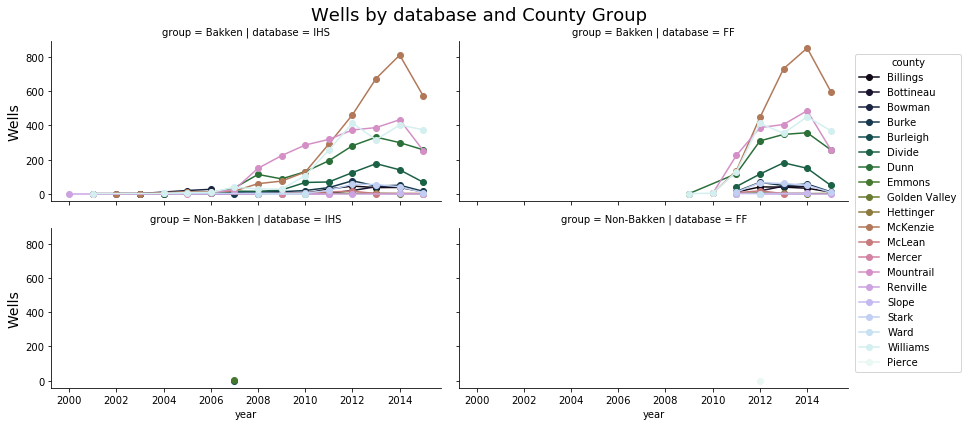

In [127]:
plt.figure(figsize=(15,5))
g = sns.FacetGrid(dat.loc[dat.variable=='Wells'], col='database', row='group',sharey=True,
                          hue = 'county',palette='cubehelix', legend_out=True,aspect = 2)
g = g.map(plt.plot,'year','value',marker='o')
g.add_legend(title='county')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Wells by database and County Group', fontsize = 18)
g.set_ylabels('Wells', fontsize=14)

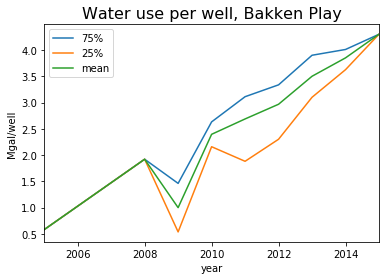

In [11]:
dwu.plot('year','75%')
ax = plt.gca()
dwu.plot('year','25%',ax=ax)
dwu.plot('year','mean',ax=ax)
plt.ylabel('Mgal/well')
plt.title('Water use per well, Bakken Play', fontsize = 16)

In [113]:
minkey = '25%'
meankey = 'mean'
maxkey = '75%'

years = list(dwu.year.unique())

def propogate(df):
    county = df.county
    year = df.year
    
    yearavail = year in years
    
    
    if (df.group == 'Bakken') & (df.variable == 'Wells') & (np.isnan(df.value)==False) & (yearavail==True):
        
        mincoef = dwu.loc[dwu.year==year,minkey].as_matrix()[0]
        meancoef = dwu.loc[dwu.year==year,meankey].as_matrix()[0]
        maxcoef = dwu.loc[dwu.year==year,maxkey].as_matrix()[0]
        
        val = float(df.value)
        
        minVal = val*mincoef
        meanVal = val*meancoef
        maxVal = val*maxcoef
        
        return county,year,minVal,meanVal,maxVal,val
    
    else:
        return county,year,np.NaN,np.NaN,np.NaN,np.NaN
        

In [114]:
res = dat.apply(propogate,axis=1)

In [117]:
county,year,minval,meanval,maxval,val = zip(*res)

In [118]:
dat['minval'] = minval
dat['meanval'] = meanval
dat['maxval'] = maxval

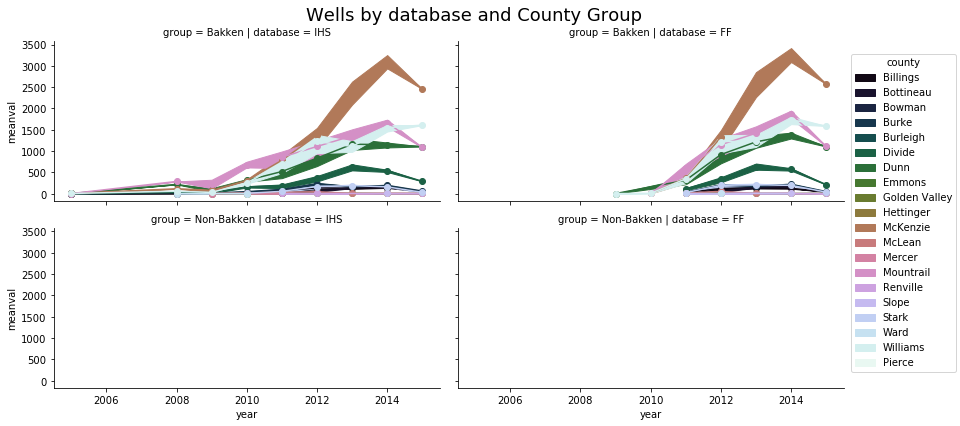

In [125]:
plt.figure(figsize=(15,5))
g = sns.FacetGrid(dat.loc[dat.variable=='Wells'], col='database', row='group',sharey=True,
                          hue = 'county',palette='cubehelix', legend_out=True,aspect = 2)
g = g.map(plt.fill_between,'year','minval','maxval')
g = g.map(plt.plot,'year','meanval',marker='o')
g.add_legend(title='county')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Wells by database and County Group', fontsize = 18)

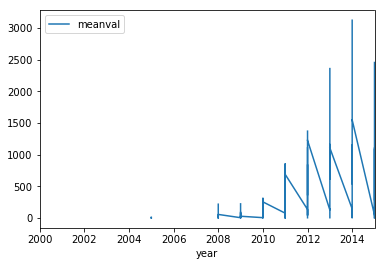

In [122]:
dat.loc[(dat.variable=='Wells') & (dat.database == 'IHS')].plot('year','meanval')